In [1]:
import datetime
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Всем привет! Здесь описано подключение к БД, примеры запросов и тд.

### Обратите внимание на признак Probability - его использование зависит от выбранного вами направления. 
### Просим в явном виде отображать его исключение в 1 направлении, мы будем каждый ноутбук проверять и прогонять модели руками (просьба не мухлевать и не использовать информацию из будущего в признаках - мы все заметим :) )

## Формат выгрузки csv-файла (столбцы):
### Для чек-поинтов - это на тренировочных данных, для финального резульата - на тестовых данных

1.   LocationId
2.   ProductId
3.   ValidationDateTime
4.   CalculatedProbability (вычисленная вами вероятность - predict_proba() )

### Также будет очень приятно, если вы нам выведите feature_importances в виде картиночки :)

In [2]:
conn_str = """
    Driver={ODBC Driver 17 for SQL Server};
    Server=109.71.11.235;
    Database=GFC.Hackathon;
    UID=participant;
    PWD=AiNRYmEatiBL;
"""

conn = pyodbc.connect(conn_str)

In [3]:
# пример запросов - здесь выведен весь датасет признаков
#query_features = "select * from dbo.Features"
#df = pd.read_sql(query_features, conn)
#df

In [4]:
#df['ValidationDateTime'] = pd.to_datetime(df['ValidationDateTime'])

In [5]:
# для обучения модели используем записи с IsCorrect is not null
train_query = "select * from dbo.Features f where f.IsCorrect is not null"
train_df = pd.read_sql(train_query, conn)
train_df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.416474,False,86.0,85.0,0.011628,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
1,63,288606,2023-06-01 15:32:31,0.687710,False,8.0,7.0,0.125000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
2,63,288606,2023-06-03 12:55:49,0.810382,False,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
3,63,288606,2023-06-07 14:57:38,0.312500,False,4.0,3.0,0.250000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
4,63,288606,2023-06-09 14:56:35,0.605429,False,6.0,5.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135842,2950,574768,2023-07-19 15:01:04,0.656481,True,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
135843,2950,575450,2023-06-20 15:00:06,0.778028,False,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
135844,2950,576459,2023-07-02 15:01:13,0.248685,False,41.0,40.0,0.024390,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
135845,2950,576631,2023-07-12 15:17:30,0.542776,True,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


In [6]:
train_df['ValidationDateTime'] = pd.to_datetime(train_df['ValidationDateTime'])

In [7]:
# тестовая выборка (то, что используется в финальном зачете) - записи с IsCorrect is null
test_query = "select * from dbo.Features f where f.IsCorrect is null"
test_df = pd.read_sql(test_query, conn)
test_df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288606,2023-07-25 14:57:04,0.406708,None,14.0,13.0,0.071429,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
1,63,288606,2023-08-03 14:58:53,0.460643,None,2.0,1.0,0.500000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
2,63,288783,2023-07-24 14:57:11,0.404959,None,4.0,4.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
3,63,288783,2023-08-03 14:57:39,0.659497,None,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
4,63,289136,2023-07-24 14:57:09,0.299769,None,6.0,6.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,2950,572875,2023-07-26 15:01:26,0.248685,None,19.0,18.0,0.052632,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40767,2950,574768,2023-07-31 15:07:00,0.173554,None,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40768,2950,576631,2023-07-26 15:01:27,0.930926,None,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40769,2950,576631,2023-07-28 15:04:19,0.704421,None,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0


In [8]:
train_df.sort_values('ValidationDateTime', inplace=True)

In [9]:
test_df.sort_values('ValidationDateTime', inplace=True)

In [10]:
train_df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
117948,2718,558125,2023-06-01 14:44:35.147,0.997800,False,1.0,-1.0,2.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
117815,2718,392473,2023-06-01 14:45:54.250,0.964307,False,1.0,-1.0,2.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
117813,2718,392392,2023-06-01 14:46:22.250,0.786700,False,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
117902,2718,495106,2023-06-01 14:49:22.857,0.970875,False,4.0,2.0,0.500000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
67140,1722,425684,2023-06-01 14:49:56.067,0.982415,False,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81151,2056,489873,2023-07-21 16:46:15.510,0.977900,True,2.0,1.0,0.500000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
80402,2022,440169,2023-07-21 16:48:18.217,0.973120,True,3.0,3.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
68471,1788,426699,2023-07-21 16:48:32.930,0.972101,True,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
68475,1788,427524,2023-07-21 16:50:45.543,0.975000,False,5.0,4.0,0.200000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


In [11]:
# дополнительные таблицы с почасовыми продажами и остатками - мы ждем отвас новых интересных признаков :)
#sales_query = "select top 100 * from dbo.LocationStateHourSales" 
#sales = pd.read_sql(sales_query, conn)
#sales

In [12]:
#stocks_query = "select top 100 * from dbo.LocationStateStocks" 
#stocks = pd.read_sql(stocks_query, conn)
#stocks

In [13]:
# csv-файл для промежуточных результатов должен быть за следующие даты
train_checkpoint = train_df.query('ValidationDateTime >= "2023-07-15"')
train_checkpoint

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
107777,2648,401972,2023-07-15 14:54:39.167,0.977865,False,0.0,-2.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
107773,2648,401971,2023-07-15 14:55:00.033,0.966208,False,12.0,10.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
661,63,510528,2023-07-15 14:58:10.000,-1.000000,True,8.0,7.0,0.125000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
66920,1719,523365,2023-07-15 14:58:10.000,0.100000,True,6.0,5.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
66605,1719,355836,2023-07-15 14:58:10.000,0.416800,False,0.0,0.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81151,2056,489873,2023-07-21 16:46:15.510,0.977900,True,2.0,1.0,0.500000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
80402,2022,440169,2023-07-21 16:48:18.217,0.973120,True,3.0,3.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
68471,1788,426699,2023-07-21 16:48:32.930,0.972101,True,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
68475,1788,427524,2023-07-21 16:50:45.543,0.975000,False,5.0,4.0,0.200000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


Загрузим полностью таблицы по продажам и остаткам

In [61]:
sales_query = "select * from dbo.LocationStateHourSales" 
sales = pd.read_sql(sales_query, conn)
sales

,LocationId,ProductId,Datetime,Quantity,PriceSum,Date
0,63,288606,2023-05-01 12:00:00,6.0,179.940002,2023-05-01
1,63,288606,2023-05-01 13:00:00,2.0,59.980000,2023-05-01
2,63,288783,2023-05-01 17:00:00,2.0,259.799988,2023-05-01
3,63,288913,2023-05-01 16:00:00,1.0,129.899994,2023-05-01
4,63,289117,2023-05-01 11:00:00,3.0,92.970001,2023-05-01
...,...,...,...,...,...,...
81932787,2950,576956,2023-08-04 08:00:00,1.0,34.990002,2023-08-04
81932788,2950,576956,2023-08-04 13:00:00,1.0,34.990002,2023-08-04
81932789,2950,576967,2023-08-04 18:00:00,3.0,89.970001,2023-08-04
81932790,2950,577090,2023-08-04 22:00:00,1.0,59.990002,2023-08-04


Точно так же приведем к datetime и отсортируем

In [62]:
sales['Datetime'] = pd.to_datetime(sales['Datetime'])

In [63]:
sales.sort_values('Datetime', inplace=True)

Сделаем новый признак. Посмотрим с какой скоростью продаются товары в среднем - средние продажи за последние 3 наблюдения (скорей всего, это получится за последние 3 часа если нет пропусков)

Эксперимент показал, что лучшие результаты получаются, если брать 3, чем 6

In [64]:
# Создаем новую колонку для хранения средней скорости продажи за последние 3 наблюдения
sales['AverageSalesSpeed'] = sales.groupby(['LocationId', 'ProductId'])['Quantity'].rolling(window=3).mean().reset_index(level=[0, 1], drop=True)

# Применяем rolling с окном 3 к колонке Quantity, группируем по LocationId и ProductId
# и вычисляем среднее внутри окна. Затем используем reset_index для удаления мультииндекса.


In [65]:
sales

,LocationId,ProductId,Datetime,Quantity,PriceSum,Date,AverageSalesSpeed
449323,2083,462074,2023-05-01 00:00:00,3.00,164.970001,2023-05-01,NaN
413928,2057,501255,2023-05-01 00:00:00,1.00,89.989998,2023-05-01,NaN
413985,2057,509147,2023-05-01 00:00:00,0.71,39.040001,2023-05-01,NaN
414003,2057,509637,2023-05-01 00:00:00,1.57,31.379999,2023-05-01,NaN
414028,2057,510537,2023-05-01 00:00:00,1.00,349.899994,2023-05-01,NaN
...,...,...,...,...,...,...,...
81819896,2670,485002,2023-08-04 23:00:00,1.00,39.990002,2023-08-04,1.000000
81637497,2201,576746,2023-08-04 23:00:00,1.00,139.899994,2023-08-04,2.000000
81462775,2009,389939,2023-08-04 23:00:00,1.00,44.990002,2023-08-04,1.000000
81803728,2659,514362,2023-08-04 23:00:00,1.00,70.989998,2023-08-04,1.000000


Теперь соединим результат с основной таблицей, по трем полям - LocationID, ProcuctID и Datetime

Для этого округлим дату в основной таблице до часов (вниз, чтобы не было заглядывания в будущее)

Кроме нового признака, из этой таблицы может быть интересно поле Quantity (т.е. объем продаж за последний час) и возможно PriceSum (может быть, дорогие и дешевые товары ведут себя по-разному?)

In [19]:
train_df['Datetime'] = train_df['ValidationDateTime'].dt.floor('H')

In [20]:
new_df = train_df.merge(sales, on=['LocationId','ProductId', 'Datetime'], how='left', copy=False) 

In [21]:
new_df.drop(['Date', 'Datetime'], axis=1, inplace=True)

In [22]:
train_df = new_df

Для таблицы остатков возьмем новый признак - остаток на начало дня.<br>
В качестве перспективы на будущее можно будет так же попробовать взять средний остаток за предыдущие 3 дня

In [26]:
stocks_query = "select * from dbo.LocationStateStocks" 
stocks = pd.read_sql(stocks_query, conn)
stocks

,LocationId,ProductId,Datetime,Quantity,Date
0,63,288524,2023-05-01 00:00:00.000,21.0,2023-05-01
1,63,288527,2023-05-01 00:00:00.000,181.0,2023-05-01
2,63,288606,2023-05-01 00:00:00.000,6.0,2023-05-01
3,63,288783,2023-05-01 00:00:00.000,11.0,2023-05-01
4,63,288817,2023-05-01 00:00:00.000,18.0,2023-05-01
...,...,...,...,...,...
113395989,2950,577062,2023-08-04 00:51:28.860,10.0,2023-08-04
113395990,2950,577063,2023-08-04 00:51:28.860,18.0,2023-08-04
113395991,2950,577090,2023-08-04 00:51:28.860,8.0,2023-08-04
113395992,2950,577093,2023-08-04 00:51:28.860,21.0,2023-08-04


In [27]:
train_df['Date'] = train_df['ValidationDateTime'].dt.floor('D')

In [28]:
stocks['Date'] = pd.to_datetime(stocks['Date'])

In [29]:
new_df = train_df.merge(stocks, on=['LocationId','ProductId', 'Date'], how='left', copy=False) 

In [33]:
new_df.drop(['Date', 'Datetime'], axis=1, inplace=True)

In [35]:
train_df = new_df

In [41]:
# Сброс ограничений на число столбцов - чтобы можно было видеть все столбцы у таблиц
pd.set_option('display.max_columns', None)

Теперь почистим данные, в том числе удалим ненужную нам Probability

Посмотрим, нет ли сильно коррелирующих между собой признаков. Если такие есть, то их можно убрать, чтобы модели было легче учиться

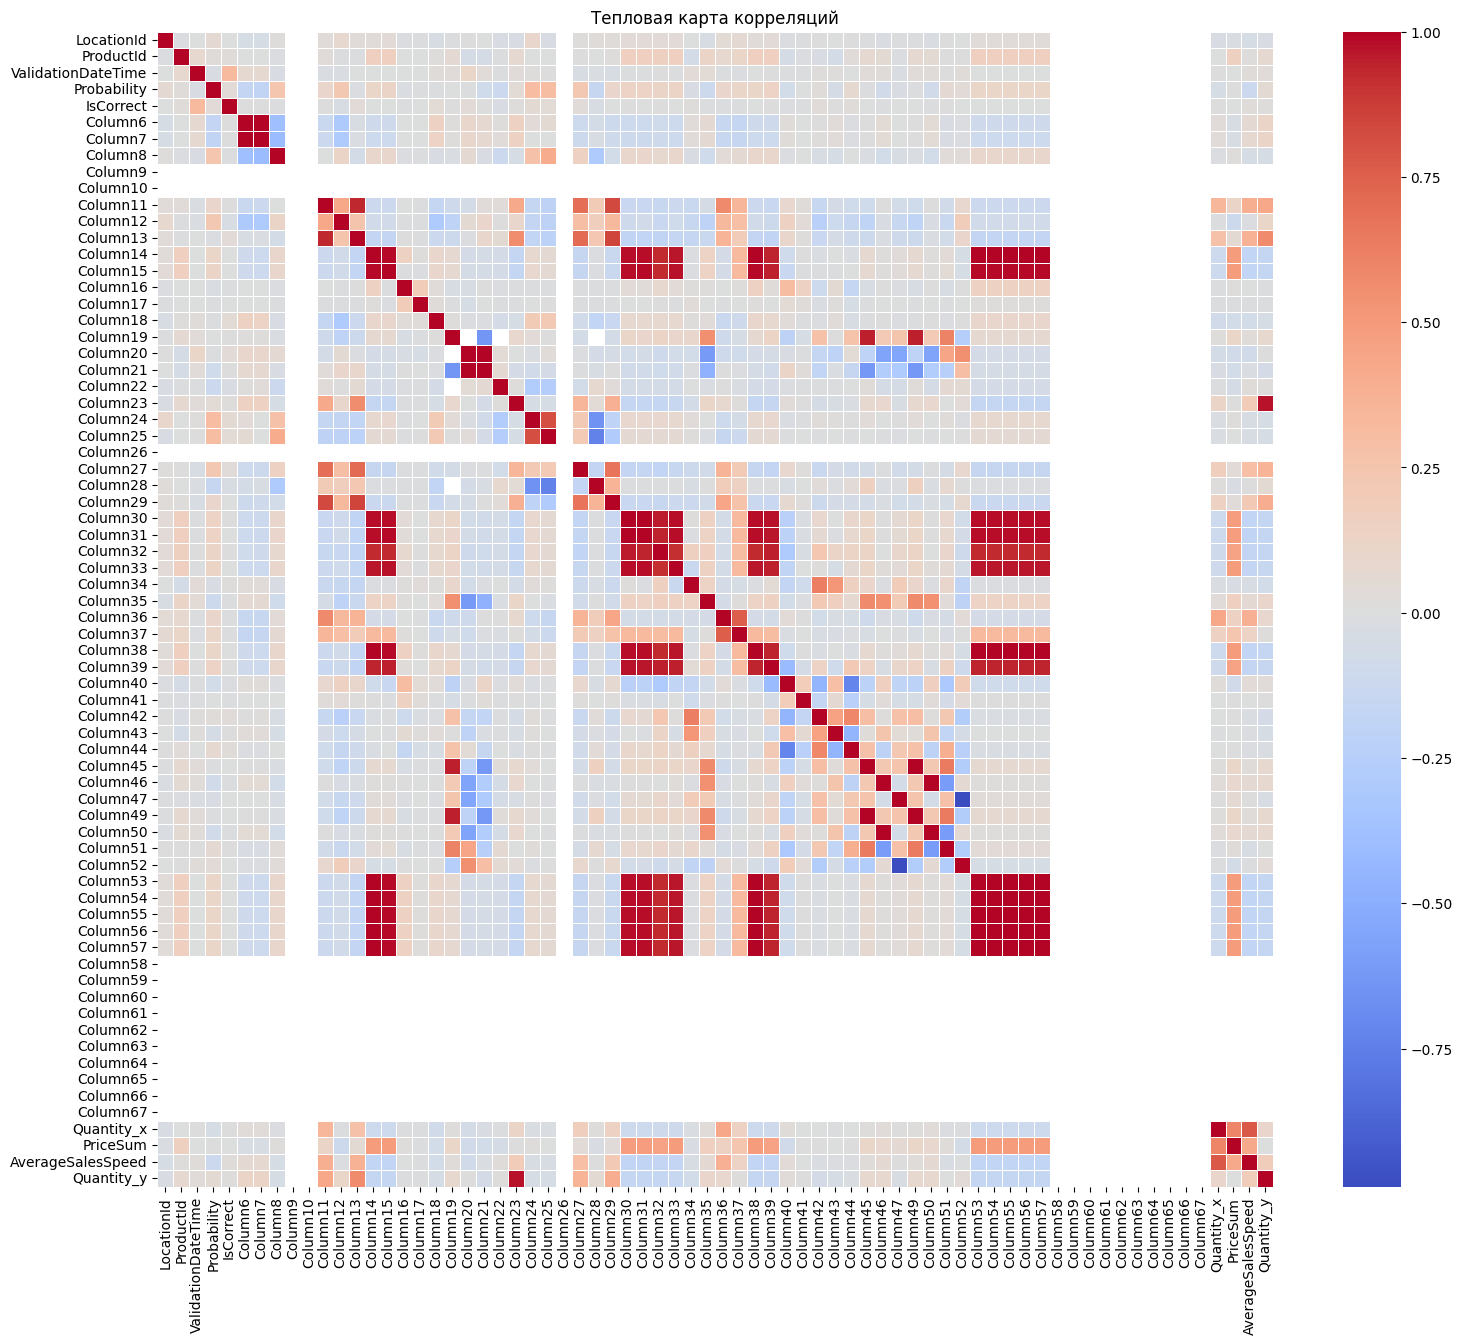

In [36]:
# Вычислим матрицу корреляций между столбцами DataFrame
correlation_matrix = train_df.corr()

# Создадим тепловую карту без численных значений
plt.figure(figsize=(18, 15))  # Настройте размер фигуры по вашим предпочтениям
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, annot=False)  # Убран параметр annot

plt.title('Тепловая карта корреляций')
plt.show()

Видим, что некоторые колонки просто "никакие", а некоторые признаки сильно коррелируют между собой, с коэффициентом 1 или близко к тому

In [37]:
train_df.drop('Probability', axis= 1 , inplace= True)  # у нас первый вариант, работаем без Probability

Удалим лишнее

In [38]:
train_df.drop(['Column9', 'Column10', 'Column26', 'Column66'], axis= 1 , inplace= True )   # тут только None
train_df.drop(['Column58', 'Column59', 'Column60', 'Column61', 'Column63', 'Column64', 'Column65', 'Column67'], axis= 1 , inplace= True )   # тут нули
train_df.drop(['Column62'], axis= 1 , inplace= True )   # тут единицы
train_df.drop(['Column7', 'Column13', 'Column15', 'Column21', 'Column31', 'Column32', 'Column33', 'Column39', 'Column54', 'Column55', 'Column56', 'Column57'], axis= 1 , inplace= True )   # тут корреляция
train_df.drop(['Column30', 'Column38', 'Column45', 'Column49'], axis= 1 , inplace= True )   # тут тоже корреляция
train_df.drop(['Column53', 'Column47', 'Column50'], axis= 1 , inplace= True )   # тут тоже корреляция


Посмотрим что получилось

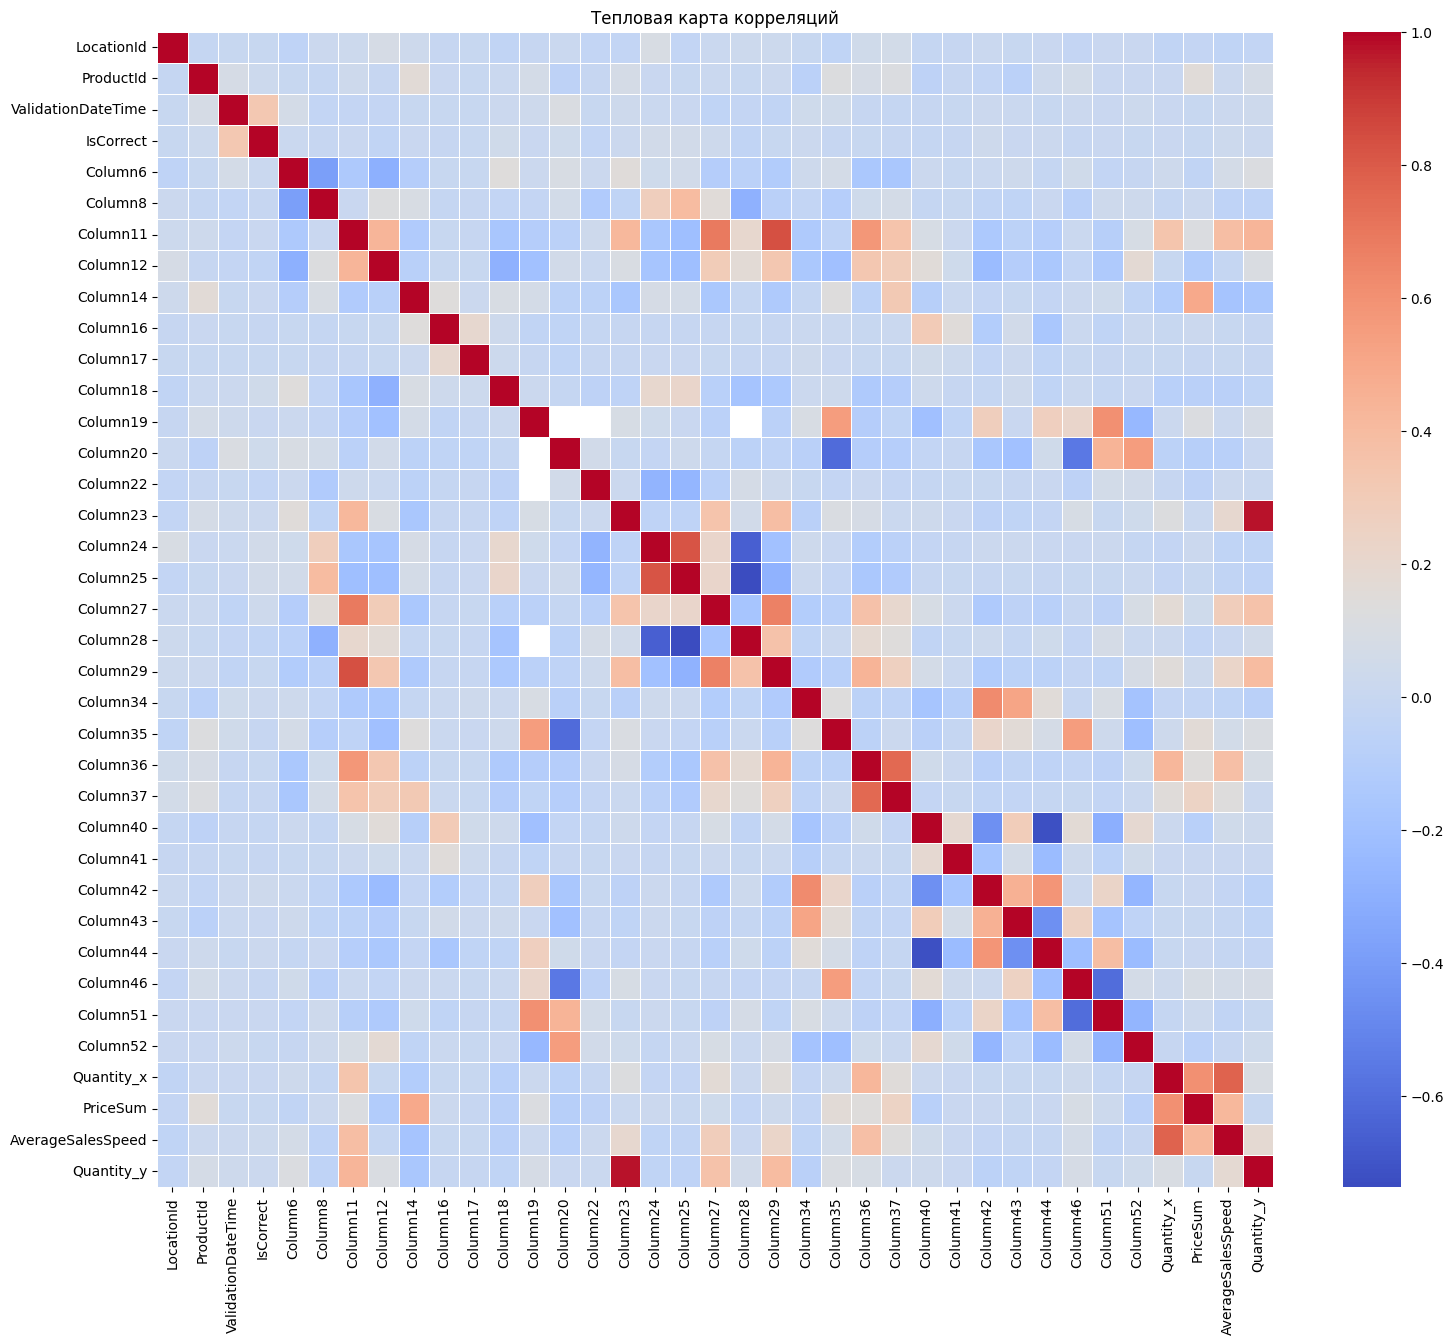

In [39]:
# Вычислим матрицу корреляций между столбцами DataFrame
correlation_matrix = train_df.corr()

# Создадим тепловую карту без численных значений
plt.figure(figsize=(18, 15))  # Настройте размер фигуры по вашим предпочтениям
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, annot=False)  # Убран параметр annot

plt.title('Тепловая карта корреляций')
plt.show()

In [42]:
train_df

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column8,Column11,Column12,Column14,Column16,Column17,Column18,Column19,Column20,Column22,Column23,Column24,Column25,Column27,Column28,Column29,Column34,Column35,Column36,Column37,Column40,Column41,Column42,Column43,Column44,Column46,Column51,Column52,Quantity_x,PriceSum,AverageSalesSpeed,Quantity_y
0,2718,558125,2023-06-01 14:44:35.147,False,1.0,2.000000,2.314357,9,121.899796,0.0,0.0,2.0,False,NaN,NaN,6.14,24,41,4.726947,1.380952,0.112546,0.056587,0.000000,3355.35791,4.085855e+05,4.066559,0.033360,0.024028,0.056587,-0.032558,False,0.0,1.0,NaN,NaN,NaN,6.14
1,2718,392473,2023-06-01 14:45:54.250,False,1.0,2.000000,1.571429,11,29.992500,0.0,0.0,0.0,False,NaN,NaN,11.00,22,39,3.549344,1.500000,0.088734,0.006685,0.000000,44498.00000,1.333347e+06,0.002501,0.000083,0.000000,0.000083,-0.000083,False,0.0,1.0,NaN,NaN,NaN,7.00
2,2718,392392,2023-06-01 14:46:22.250,False,0.0,NaN,5.535714,18,36.490002,0.0,0.0,0.0,False,NaN,NaN,-2.00,9,17,3.705899,1.888889,0.205883,0.084060,0.000000,149888.00000,5.512260e+06,0.000000,0.000000,0.064119,0.064119,0.000000,False,0.0,1.0,1.0,36.490002,1.333333,1.00
3,2718,495106,2023-06-01 14:49:22.857,False,4.0,0.500000,2.321429,7,137.461655,0.0,0.0,0.0,True,NaN,NaN,17.00,24,41,4.327801,NaN,0.103043,0.034024,0.600000,14950.00000,2.076597e+06,-2.438339,-0.017738,0.017429,0.000000,0.017429,False,1.0,0.0,NaN,NaN,NaN,11.00
4,1722,425684,2023-06-01 14:49:56.067,False,1.0,1.000000,1.678571,15,39.990002,0.0,0.0,2.0,False,NaN,NaN,38.00,17,27,2.068784,0.857143,0.073885,0.024506,0.000000,3321.00000,1.325152e+05,0.000000,0.000000,0.000000,0.000000,0.000000,False,0.0,1.0,NaN,NaN,NaN,37.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135842,2056,489873,2023-07-21 16:46:15.510,True,2.0,0.500000,2.428571,25,99.989998,0.0,0.0,2.0,False,NaN,NaN,5.00,24,23,2.632800,1.166667,0.109700,0.116512,0.000000,144649.00000,1.399979e+07,1.000000,0.010001,0.000000,0.010001,-0.010001,False,0.0,1.0,NaN,NaN,NaN,0.00
135843,2022,440169,2023-07-21 16:48:18.217,True,3.0,0.000000,16.214285,26,64.767494,0.0,0.0,0.0,False,NaN,NaN,47.00,6,5,4.576834,3.666667,0.762806,0.112652,0.000000,137535.00000,9.508136e+06,-8.175835,-0.126234,0.112652,0.000639,0.112013,False,0.0,1.0,NaN,NaN,NaN,35.00
135844,1788,426699,2023-07-21 16:48:32.930,True,3.0,0.333333,7.750000,21,17.990000,0.0,0.0,2.0,True,NaN,NaN,80.00,16,24,9.532596,NaN,0.381304,0.180100,0.647773,133380.00000,2.296204e+06,0.000000,0.000000,0.000000,0.000000,0.000000,True,0.0,1.0,NaN,NaN,NaN,80.00
135845,1788,427524,2023-07-21 16:50:45.543,False,5.0,0.200000,4.750000,17,20.730000,0.0,0.0,0.0,True,NaN,NaN,172.00,14,22,5.745009,NaN,0.249783,0.357270,0.978873,76680.00000,1.541608e+06,1.709999,0.082489,0.259378,0.320472,-0.061093,True,0.0,1.0,NaN,NaN,NaN,168.00


Column23 сильно коррелирует с Quantity_y, т.е. с остатком товара на начало дня. Но оставим. Судя по числам, совпадения 1:1 все же нет.

In [43]:
train_df.IsCorrect = train_df.IsCorrect.replace({True: 1, False: 0})    

In [44]:
train_df.Column19 = train_df.Column19.replace({True: 1, False: 0})
train_df.Column46 = train_df.Column46.replace({True: 1, False: 0})

In [44]:
train_df.loc[train_df.Column46.isnull()]

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column8,Column11,Column12,Column14,Column16,Column17,Column18,Column19,Column20,Column22,Column23,Column24,Column25,Column27,Column28,Column29,Column34,Column35,Column36,Column37,Column40,Column41,Column42,Column43,Column44,Column46,Column51,Column52,Quantity,PriceSum,AverageSalesSpeed
57,2526,430941,2023-06-01 15:07:18.230,0,3.0,0.333333,0.535714,1,249.899994,0.000000,0.000000,0.0,1,NaN,NaN,15.0,21,29,2.196720,NaN,0.073224,0.000000,1.000000,3148.0,7.866852e+05,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
99,1713,495106,2023-06-01 15:18:27.500,0,0.0,NaN,0.928571,3,139.899994,0.000000,0.000000,0.0,1,NaN,NaN,12.0,19,40,1.285079,NaN,0.031343,0.001272,1.000000,5382.0,7.524096e+05,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
171,2667,430941,2023-06-01 15:26:57.253,1,3.0,0.333333,0.714286,4,249.389984,0.000000,0.000000,0.0,1,NaN,NaN,15.0,23,23,1.206430,NaN,0.050268,0.168423,0.833333,18888.0,4.873498e+06,NaN,NaN,0.168423,NaN,NaN,NaN,NaN,0.0,1.0,249.899994,1.166667
196,2632,326068,2023-06-01 15:31:46.260,1,4.0,0.250000,4.142857,6,89.989998,0.000000,0.000000,0.0,1,NaN,NaN,46.0,17,17,6.980474,NaN,0.387804,0.513304,0.843750,7424.0,7.626791e+05,NaN,NaN,0.513304,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
960,2567,445032,2023-06-01 15:39:49.000,0,4.0,0.250000,1.321429,7,139.899994,0.000000,0.000000,1.0,1,NaN,NaN,21.0,12,20,1.624656,NaN,0.077365,0.176574,0.952381,9555.0,1.445944e+06,-30.0,-0.214439,0.176574,0.0,0.176574,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134358,2803,341568,2023-07-21 15:01:23.000,1,64.0,0.015625,0.607143,4,99.989998,0.000000,0.000000,0.0,1,NaN,NaN,29.0,9,18,0.521897,NaN,0.027468,0.004367,1.000000,13073.0,1.304147e+06,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
134382,2803,519847,2023-07-21 15:01:25.000,1,7.0,0.142857,0.964286,3,49.990002,0.000000,0.000000,1.0,1,NaN,NaN,35.0,15,24,2.530123,NaN,0.101205,0.000000,0.777778,40419.0,2.020546e+06,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
134764,1669,507558,2023-07-21 15:02:10.000,0,2.0,0.500000,1.785714,6,399.029999,69.629974,0.211384,1.0,1,NaN,NaN,17.0,11,21,0.394491,NaN,0.017931,0.177294,0.960000,32900.0,1.111471e+07,NaN,NaN,0.002176,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
134853,1391,483352,2023-07-21 15:07:53.793,1,1.0,1.000000,0.571429,6,119.827499,0.000000,0.000000,0.0,1,NaN,NaN,35.0,9,18,0.865729,NaN,0.045565,0.200617,0.888889,5382.0,7.168884e+05,NaN,NaN,0.200617,NaN,NaN,NaN,NaN,0.0,1.0,119.900002,1.000000


Заполним пропуски наиболее часто встречающимся значением

In [45]:
train_df['Column46'].fillna(value=0, inplace=True)   # надо бы еще поанализировать но пока заполним наиболее частым значением
train_df['Column46'] = pd.to_numeric(train_df['Column46'])
train_df['Column46'] = train_df['Column46'].astype (int)

В 19 колонке nan-ов нет, поэтому fillna не нужно

In [46]:
train_df['Column51'].fillna(value=0, inplace=True) 
train_df['Column52'].fillna(value=1, inplace=True) 
train_df['Column51'] = train_df['Column51'].astype (int)
train_df['Column52'] = train_df['Column52'].astype (int)

In [47]:
train_df

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column8,Column11,Column12,Column14,Column16,Column17,Column18,Column19,Column20,Column22,Column23,Column24,Column25,Column27,Column28,Column29,Column34,Column35,Column36,Column37,Column40,Column41,Column42,Column43,Column44,Column46,Column51,Column52,Quantity_x,PriceSum,AverageSalesSpeed,Quantity_y
0,2718,558125,2023-06-01 14:44:35.147,0,1.0,2.000000,2.314357,9,121.899796,0.0,0.0,2.0,0,NaN,NaN,6.14,24,41,4.726947,1.380952,0.112546,0.056587,0.000000,3355.35791,4.085855e+05,4.066559,0.033360,0.024028,0.056587,-0.032558,0,0,1,NaN,NaN,NaN,6.14
1,2718,392473,2023-06-01 14:45:54.250,0,1.0,2.000000,1.571429,11,29.992500,0.0,0.0,0.0,0,NaN,NaN,11.00,22,39,3.549344,1.500000,0.088734,0.006685,0.000000,44498.00000,1.333347e+06,0.002501,0.000083,0.000000,0.000083,-0.000083,0,0,1,NaN,NaN,NaN,7.00
2,2718,392392,2023-06-01 14:46:22.250,0,0.0,NaN,5.535714,18,36.490002,0.0,0.0,0.0,0,NaN,NaN,-2.00,9,17,3.705899,1.888889,0.205883,0.084060,0.000000,149888.00000,5.512260e+06,0.000000,0.000000,0.064119,0.064119,0.000000,0,0,1,1.0,36.490002,1.333333,1.00
3,2718,495106,2023-06-01 14:49:22.857,0,4.0,0.500000,2.321429,7,137.461655,0.0,0.0,0.0,1,NaN,NaN,17.00,24,41,4.327801,NaN,0.103043,0.034024,0.600000,14950.00000,2.076597e+06,-2.438339,-0.017738,0.017429,0.000000,0.017429,0,1,0,NaN,NaN,NaN,11.00
4,1722,425684,2023-06-01 14:49:56.067,0,1.0,1.000000,1.678571,15,39.990002,0.0,0.0,2.0,0,NaN,NaN,38.00,17,27,2.068784,0.857143,0.073885,0.024506,0.000000,3321.00000,1.325152e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,NaN,NaN,NaN,37.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135842,2056,489873,2023-07-21 16:46:15.510,1,2.0,0.500000,2.428571,25,99.989998,0.0,0.0,2.0,0,NaN,NaN,5.00,24,23,2.632800,1.166667,0.109700,0.116512,0.000000,144649.00000,1.399979e+07,1.000000,0.010001,0.000000,0.010001,-0.010001,0,0,1,NaN,NaN,NaN,0.00
135843,2022,440169,2023-07-21 16:48:18.217,1,3.0,0.000000,16.214285,26,64.767494,0.0,0.0,0.0,0,NaN,NaN,47.00,6,5,4.576834,3.666667,0.762806,0.112652,0.000000,137535.00000,9.508136e+06,-8.175835,-0.126234,0.112652,0.000639,0.112013,0,0,1,NaN,NaN,NaN,35.00
135844,1788,426699,2023-07-21 16:48:32.930,1,3.0,0.333333,7.750000,21,17.990000,0.0,0.0,2.0,1,NaN,NaN,80.00,16,24,9.532596,NaN,0.381304,0.180100,0.647773,133380.00000,2.296204e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,1,NaN,NaN,NaN,80.00
135845,1788,427524,2023-07-21 16:50:45.543,0,5.0,0.200000,4.750000,17,20.730000,0.0,0.0,0.0,1,NaN,NaN,172.00,14,22,5.745009,NaN,0.249783,0.357270,0.978873,76680.00000,1.541608e+06,1.709999,0.082489,0.259378,0.320472,-0.061093,1,0,1,NaN,NaN,NaN,168.00


Еще сгенерируем признаки: месяц, день недели, час и минута валидационной сессии отдельно

In [48]:
#train_df['ValidationDateTime'] = pd.to_datetime(train_df['ValidationDateTime'])
train_df['month'] = train_df['ValidationDateTime'].dt.strftime('%B')
train_df['dayofweek'] = train_df['ValidationDateTime'].dt.strftime('%A')
train_df["hour"] = train_df["ValidationDateTime"].dt.hour
train_df["minute"] = train_df["ValidationDateTime"].dt.minute
train_df
#train_df.drop('ValidationDateTime', axis=1)

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column8,Column11,Column12,Column14,Column16,Column17,Column18,Column19,Column20,Column22,Column23,Column24,Column25,Column27,Column28,Column29,Column34,Column35,Column36,Column37,Column40,Column41,Column42,Column43,Column44,Column46,Column51,Column52,Quantity_x,PriceSum,AverageSalesSpeed,Quantity_y,month,dayofweek,hour,minute
0,2718,558125,2023-06-01 14:44:35.147,0,1.0,2.000000,2.314357,9,121.899796,0.0,0.0,2.0,0,NaN,NaN,6.14,24,41,4.726947,1.380952,0.112546,0.056587,0.000000,3355.35791,4.085855e+05,4.066559,0.033360,0.024028,0.056587,-0.032558,0,0,1,NaN,NaN,NaN,6.14,June,Thursday,14,44
1,2718,392473,2023-06-01 14:45:54.250,0,1.0,2.000000,1.571429,11,29.992500,0.0,0.0,0.0,0,NaN,NaN,11.00,22,39,3.549344,1.500000,0.088734,0.006685,0.000000,44498.00000,1.333347e+06,0.002501,0.000083,0.000000,0.000083,-0.000083,0,0,1,NaN,NaN,NaN,7.00,June,Thursday,14,45
2,2718,392392,2023-06-01 14:46:22.250,0,0.0,NaN,5.535714,18,36.490002,0.0,0.0,0.0,0,NaN,NaN,-2.00,9,17,3.705899,1.888889,0.205883,0.084060,0.000000,149888.00000,5.512260e+06,0.000000,0.000000,0.064119,0.064119,0.000000,0,0,1,1.0,36.490002,1.333333,1.00,June,Thursday,14,46
3,2718,495106,2023-06-01 14:49:22.857,0,4.0,0.500000,2.321429,7,137.461655,0.0,0.0,0.0,1,NaN,NaN,17.00,24,41,4.327801,NaN,0.103043,0.034024,0.600000,14950.00000,2.076597e+06,-2.438339,-0.017738,0.017429,0.000000,0.017429,0,1,0,NaN,NaN,NaN,11.00,June,Thursday,14,49
4,1722,425684,2023-06-01 14:49:56.067,0,1.0,1.000000,1.678571,15,39.990002,0.0,0.0,2.0,0,NaN,NaN,38.00,17,27,2.068784,0.857143,0.073885,0.024506,0.000000,3321.00000,1.325152e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,NaN,NaN,NaN,37.00,June,Thursday,14,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135842,2056,489873,2023-07-21 16:46:15.510,1,2.0,0.500000,2.428571,25,99.989998,0.0,0.0,2.0,0,NaN,NaN,5.00,24,23,2.632800,1.166667,0.109700,0.116512,0.000000,144649.00000,1.399979e+07,1.000000,0.010001,0.000000,0.010001,-0.010001,0,0,1,NaN,NaN,NaN,0.00,July,Friday,16,46
135843,2022,440169,2023-07-21 16:48:18.217,1,3.0,0.000000,16.214285,26,64.767494,0.0,0.0,0.0,0,NaN,NaN,47.00,6,5,4.576834,3.666667,0.762806,0.112652,0.000000,137535.00000,9.508136e+06,-8.175835,-0.126234,0.112652,0.000639,0.112013,0,0,1,NaN,NaN,NaN,35.00,July,Friday,16,48
135844,1788,426699,2023-07-21 16:48:32.930,1,3.0,0.333333,7.750000,21,17.990000,0.0,0.0,2.0,1,NaN,NaN,80.00,16,24,9.532596,NaN,0.381304,0.180100,0.647773,133380.00000,2.296204e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,1,NaN,NaN,NaN,80.00,July,Friday,16,48
135845,1788,427524,2023-07-21 16:50:45.543,0,5.0,0.200000,4.750000,17,20.730000,0.0,0.0,0.0,1,NaN,NaN,172.00,14,22,5.745009,NaN,0.249783,0.357270,0.978873,76680.00000,1.541608e+06,1.709999,0.082489,0.259378,0.320472,-0.061093,1,0,1,NaN,NaN,NaN,168.00,July,Friday,16,50


Разделим на обучающую и тестовую выборки 80:20

In [51]:
train2=train_df.sample(frac=0.8,random_state=239)
test2=train_df.drop(train2.index)

In [52]:
train2

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column8,Column11,Column12,Column14,Column16,Column17,Column18,Column19,Column20,Column22,Column23,Column24,Column25,Column27,Column28,Column29,Column34,Column35,Column36,Column37,Column40,Column41,Column42,Column43,Column44,Column46,Column51,Column52,Quantity_x,PriceSum,AverageSalesSpeed,Quantity_y,month,dayofweek,hour,minute
44186,2931,320576,2023-06-23 15:00:01.000,0,4.0,0.250000,3.250000,27,57.990002,0.000000,0.000000,0.0,1,NaN,NaN,11.0,11,19,3.242249,NaN,0.162112,0.082198,0.495413,100825.0,5.721449e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,1,1.0,57.990002,1.333333,8.0,June,Friday,15,0
62494,1524,375354,2023-06-30 15:27:25.370,0,11.0,0.181818,5.107143,23,38.490002,0.000000,0.000000,2.0,0,5.0,1.0,20.0,23,44,6.129871,1.222222,0.136219,0.071429,0.590062,25921.0,9.946532e+05,0.480003,0.012471,0.012824,0.025135,-0.012311,1,-1,0,NaN,NaN,NaN,19.0,June,Friday,15,27
4824,2663,323969,2023-06-04 16:31:49.727,0,0.0,NaN,3.035714,21,64.989998,1.488335,0.023438,2.0,1,NaN,NaN,13.0,14,23,3.143464,NaN,0.130978,0.287470,0.313433,70484.0,4.480826e+06,-5.000000,-0.076935,0.071439,0.000000,0.071439,0,1,0,NaN,NaN,NaN,18.0,June,Sunday,16,31
101991,1159,561139,2023-07-12 15:16:07.000,1,58.0,0.017241,0.250000,3,59.990002,0.000000,0.000000,2.0,1,NaN,NaN,6.0,19,27,0.339740,NaN,0.012134,0.000000,1.000000,651.0,3.905349e+04,NaN,NaN,0.000000,NaN,NaN,0,0,0,NaN,NaN,NaN,6.0,July,Wednesday,15,16
11921,2497,563946,2023-06-08 15:00:50.000,0,3.0,0.333333,6.535714,28,69.989998,0.000000,0.000000,0.0,1,NaN,NaN,46.0,11,19,5.605155,NaN,0.280258,0.389726,0.690763,262695.0,1.661899e+07,-10.000000,-0.142878,0.125016,0.000000,0.125016,0,1,0,NaN,NaN,NaN,43.0,June,Thursday,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89717,84,304642,2023-07-09 14:57:47.000,0,1.0,1.000000,4.892857,25,74.989998,0.000000,0.000000,0.0,0,11.0,1.0,13.0,10,19,5.125761,1.700000,0.256288,0.376634,0.652439,181384.0,9.936570e+06,20.122498,0.268336,0.000000,0.268336,-0.268336,0,0,1,NaN,NaN,NaN,8.0,July,Sunday,14,57
85900,2336,310890,2023-07-07 16:02:57.823,0,8.0,0.125000,1.000000,13,80.989998,25.216663,0.452128,2.0,0,5.0,1.0,6.0,16,24,1.078723,1.080000,0.043149,0.380227,0.147059,31450.0,2.165444e+06,-9.000000,-0.111125,0.100011,0.000000,0.100011,0,0,1,NaN,NaN,NaN,6.0,July,Friday,16,2
53468,2708,515994,2023-06-27 14:59:45.000,0,8.0,0.125000,8.178572,26,85.989998,0.000000,0.000000,0.0,0,16.0,1.0,17.0,8,17,5.484697,2.000000,0.304705,0.465503,0.356000,374250.0,2.594711e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,NaN,NaN,NaN,15.0,June,Tuesday,14,59
5579,2582,490218,2023-06-05 15:01:10.000,0,5.0,0.200000,1.928571,11,119.900002,0.000000,0.000000,1.0,0,2.0,1.0,4.0,9,17,2.087985,2.000000,0.115999,0.259744,0.448276,34684.0,3.792624e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,NaN,NaN,NaN,4.0,June,Monday,15,1


Будем использовать Catboost. Catboost очень хорошо себя показывает на задачах классификации

In [53]:
from catboost import CatBoostClassifier   

target_col = 'IsCorrect'
#X_train = train_df.drop(columns=[target_col])
#y_train = train_df[target_col]

X_train = train2.drop(columns=[target_col])
y_train = train2[target_col]

X_eval = test2.drop(columns=[target_col])
y_eval = test2[target_col]

Сделаем глубину деревьев побольше (по умолчанию оно 6), будем интереса ради считать и другие метрики, и будем контролировать переобучение. <br>
У нас остается признак PriceSum из таблицы продаж - но эксперименты показали, что он только мешает и при его использовании результат ниже. Проигнорируем его.

In [54]:
# Создаем и обучаем модель CatBoost
model = CatBoostClassifier(iterations=1000, depth=16, learning_rate=0.1,
                          verbose=10,
                          loss_function='Logloss', 
                          eval_metric='AUC',
                          custom_metric=['AUC', 'F1', 'Precision', 'Recall'],
                          early_stopping_rounds=20,
                          use_best_model=True,
                          random_seed=239,
                          cat_features=['Column19', 'Column46', 'month', 'dayofweek'],
                          ignored_features=['ValidationDateTime', 'PriceSum']
                          )
model.fit(X_train, y_train, eval_set=(X_eval,y_eval), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6958696	best: 0.6958696 (0)	total: 2.59s	remaining: 43m 6s
10:	test: 0.7601362	best: 0.7601362 (10)	total: 24.3s	remaining: 36m 25s
20:	test: 0.7722544	best: 0.7730167 (16)	total: 50.3s	remaining: 39m 4s
30:	test: 0.7885575	best: 0.7885575 (30)	total: 1m 14s	remaining: 38m 50s
40:	test: 0.7919985	best: 0.7923392 (39)	total: 1m 40s	remaining: 39m 12s
50:	test: 0.7958557	best: 0.7958557 (50)	total: 2m 4s	remaining: 38m 38s
60:	test: 0.7997753	best: 0.7998143 (59)	total: 2m 30s	remaining: 38m 38s
70:	test: 0.8008420	best: 0.8010134 (66)	total: 2m 54s	remaining: 38m 7s
80:	test: 0.8038723	best: 0.8042129 (79)	total: 3m 18s	remaining: 37m 35s
90:	test: 0.8052521	best: 0.8052787 (89)	total: 3m 43s	remaining: 37m 14s
100:	test: 0.8056713	best: 0.8056713 (100)	total: 4m 5s	remaining: 36m 24s
110:	test: 0.8098656	best: 0.8098901 (108)	total: 4m 30s	remaining: 36m 7s
120:	test: 0.8149758	best: 0.8149758 (120)	total: 4m 59s	remaining: 36m 13s
130:	test: 0.8183708	best: 0.8188967 (127)	

In [55]:
model.get_best_score()

{'learn': {'Recall': 1.0,
  'F1': 1.0,
  'Logloss': 0.02139199089361087,
  'Precision': 1.0},
 'validation': {'Recall': 0.36662371134020616,
  'F1': 0.4962389621715905,
  'Logloss': 0.4043128030428905,
  'Precision': 0.7695757157640566,
  'AUC': 0.8440155505413343}}

In [56]:
model.get_best_iteration()  # если val датасет не задан, будет пусто

495

Посмотрим, какие признаки имеют значение

In [58]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,LocationId,8.810605
1,dayofweek,8.796053
2,month,8.004947
3,minute,7.733533
4,ProductId,4.540627
5,Column8,3.993048
6,Column18,3.833263
7,Column14,3.442517
8,Column34,3.397589
9,Column35,3.256392


Напомним, здесь Quantity_x - это Quantity из доп.таблицы по продажам, а Quantity_y - из доп.таблицы остатков.

Чтобы было приятно организаторам, покажем красивую картинку, как просили :)

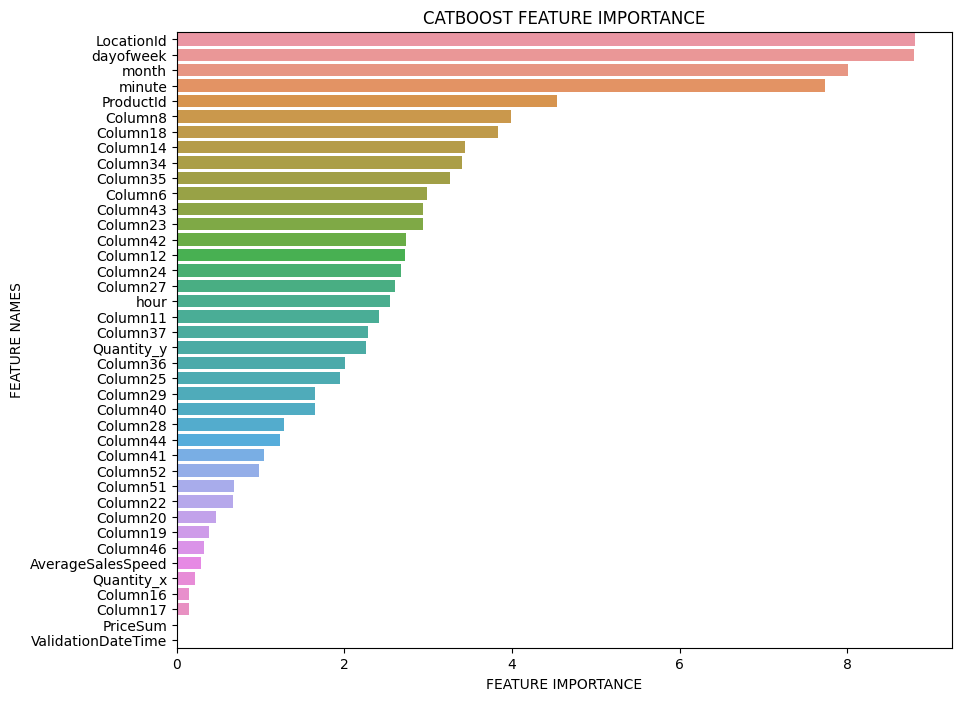

In [59]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')

Аналогично теперь обработаем и test_df для предсказания

In [67]:
test_df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
24,63,292487,2023-07-22 14:57:43.000,NaN,None,4.0,3.0,0.25,None,None,2.750000,17,NaN,19.990000,19.990000,0.0,0.000000,1.0,True,NaN,-1.0,NaN,22.0,18,27,None,NaN,NaN,NaN,19.017485,18.780886,22.490000,9.120000,0.594486,0.518987,33496.0,6.290846e+05,19.990000,9.120000,10.870000,0.543772,1.111605e-01,5.944864e-01,-0.483326,True,True,False,1.0,1.0,0.0,1.0,19.990000,19.990000,19.990000,19.990000,19.990000,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
29,63,292489,2023-07-22 14:57:43.000,NaN,None,4.0,3.0,0.25,None,None,4.178571,19,NaN,19.990000,19.990000,0.0,0.000000,0.0,True,NaN,-1.0,NaN,25.0,9,18,None,NaN,NaN,NaN,19.321909,19.082809,22.490000,17.550833,0.219616,0.702479,51304.0,9.790245e+05,19.990000,17.990908,1.999092,0.100005,1.111605e-01,2.000486e-01,-0.088888,True,True,False,1.0,1.0,0.0,1.0,19.990000,19.990000,19.990000,19.990000,19.990000,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
139,63,425438,2023-07-22 14:57:43.000,NaN,None,4.0,3.0,0.25,None,None,7.571429,24,NaN,16.238001,16.238001,0.0,0.000000,1.0,True,NaN,-1.0,NaN,86.0,9,18,None,NaN,NaN,NaN,17.788071,17.715454,18.990000,16.238001,0.144918,0.611570,130680.0,2.315056e+06,16.238001,17.990000,-1.751999,-0.107895,1.449183e-01,5.265930e-02,0.092259,True,True,False,1.0,1.0,0.0,1.0,16.238001,16.238001,16.238001,16.238001,16.238001,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
246,63,514225,2023-07-22 14:57:43.000,NaN,None,7.0,7.0,0.00,None,None,2.821429,19,NaN,44.910000,44.910000,0.0,0.000000,1.0,True,NaN,0.0,NaN,8.0,7,6,None,NaN,NaN,NaN,48.968464,48.372002,49.990002,44.797997,0.103861,0.677778,2520.0,1.218974e+05,44.910000,49.990002,-5.080002,-0.113115,1.016204e-01,0.000000e+00,0.101620,True,False,True,1.0,0.0,1.0,0.0,44.910000,44.910000,44.910000,44.910000,44.910000,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
149,63,425891,2023-07-22 14:57:43.000,0.229745,None,2.0,1.0,0.50,None,None,5.000000,16,NaN,6.390000,6.390000,0.0,0.000000,1.0,False,NaN,NaN,NaN,36.0,9,18,None,2.377256,1.842105,0.125119,6.305430,6.349073,6.390000,5.610000,0.122066,0.000000,40166.0,2.550169e+05,6.390000,6.390000,0.000000,0.000000,7.462240e-08,7.462240e-08,0.000000,False,False,False,0.0,0.0,0.0,1.0,6.390000,6.390000,6.390000,6.390000,6.390000,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,266,463578,2023-08-04 17:01:44.807,0.981780,None,1.0,-1.0,2.00,None,None,1.464286,15,1.571429,119.900002,119.900002,0.0,0.000000,2.0,False,NaN,-2.0,NaN,7.0,20,39,None,2.382898,0.350000,0.059572,143.968994,135.155121,159.899994,111.907501,0.300141,0.292683,5658.0,7.647077e+05,119.900002,142.477493,-22.577492,-0.188303,2.501563e-01,1.089587e-01,0.141198,True,False,True,1.0,0.0,1.0,0.0,119.900002,119.900002,119.900002,119.900002,119.900002,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
6060,541,443131,2023-08-04 17:06:18.010,0.989127,None,4.0,3.0,0.25,None,None,1.071429,14,1.875000,139.899994,179.899994,-40.0,-0.222346,3.0,False,16.0,15.0,1.0,5.0,10,19,None,1.435840,1.600000,0.071792,146.201950,142.430573,179.899994,114.653328,0.362683,0.485714,15925.0,2.268207e+06,139.899994,139.899994,0.000000,0.000000,2.223458e-01,2.223458e-01,0.000000,False,False,False,0.0,0.0,0.0,1.0,139.899994,139.899994,139.899994,139.899994,139.899994,0.0,0.0,0.0

In [68]:
test_df.drop(['Column9', 'Column10', 'Column26', 'Column66'], axis= 1 , inplace= True )   # тут только None
test_df.drop(['Column58', 'Column59', 'Column60', 'Column61', 'Column63', 'Column64', 'Column65', 'Column67'], axis= 1 , inplace= True )   # тут нули
test_df.drop(['Column62'], axis= 1 , inplace= True )   # тут единицы
test_df.drop(['Column7', 'Column13', 'Column15', 'Column21', 'Column31', 'Column32', 'Column33', 'Column39', 'Column54', 'Column55', 'Column56', 'Column57'], axis= 1 , inplace= True )   # тут корреляция
test_df.drop(['Column30', 'Column38', 'Column45', 'Column49'], axis= 1 , inplace= True )   # тут тоже корреляция
test_df.drop(['Column53', 'Column47', 'Column50'], axis= 1 , inplace= True )   # тут тоже корреляция


In [69]:
test_df.drop(['Probability', 'IsCorrect'], axis= 1 , inplace= True )    

In [70]:
test_df.Column19 = train_checkpoint.Column19.replace({True: 1, False: 0})
test_df.Column46 = train_checkpoint.Column46.replace({True: 1, False: 0})

In [71]:
test_df['Column19'].fillna(value=0, inplace=True)
test_df['Column46'].fillna(value=0, inplace=True)

In [72]:
test_df['Column19'] = test_df['Column46'].astype(int)
test_df['Column46'] = test_df['Column46'].astype(int)

In [85]:
test_df['Column51'].fillna(value=0, inplace=True) 
test_df['Column52'].fillna(value=1, inplace=True) 
test_df['Column51'] = test_df['Column51'].astype (int)
test_df['Column52'] = test_df['Column52'].astype (int)

In [73]:
test_df['Datetime'] = test_df['ValidationDateTime'].dt.floor('H')

In [74]:
new_df = test_df.merge(sales, on=['LocationId','ProductId', 'Datetime'], how='left', copy=False) 

In [75]:
new_df.drop(['Date', 'Datetime'], axis=1, inplace=True)

In [76]:
test_df = new_df

In [77]:
test_df['Date'] = test_df['ValidationDateTime'].dt.floor('D')

In [78]:
new_df = test_df.merge(stocks, on=['LocationId','ProductId', 'Date'], how='left', copy=False) 

In [79]:
new_df.drop(['Date', 'Datetime'], axis=1, inplace=True)

In [80]:
test_df = new_df

In [84]:
test_df['month'] = test_df['ValidationDateTime'].dt.strftime('%B')
test_df['dayofweek'] = test_df['ValidationDateTime'].dt.strftime('%A')
test_df["hour"] = test_df["ValidationDateTime"].dt.hour
test_df["minute"] = test_df["ValidationDateTime"].dt.minute
test_df

,LocationId,ProductId,ValidationDateTime,Column6,Column8,Column11,Column12,Column14,Column16,Column17,Column18,Column19,Column20,Column22,Column23,Column24,Column25,Column27,Column28,Column29,Column34,Column35,Column36,Column37,Column40,Column41,Column42,Column43,Column44,Column46,Column51,Column52,Quantity_x,PriceSum,AverageSalesSpeed,Quantity_y,month,dayofweek,hour,minute
0,63,292487,2023-07-22 14:57:43.000,4.0,0.25,2.750000,17,19.990000,0.0,0.000000,1.0,0,NaN,NaN,22.0,18,27,NaN,NaN,NaN,0.594486,0.518987,33496.0,6.290846e+05,10.870000,0.543772,1.111605e-01,5.944864e-01,-0.483326,0,0.0,1.0,NaN,NaN,NaN,22.0,July,Saturday,14,57
1,63,292489,2023-07-22 14:57:43.000,4.0,0.25,4.178571,19,19.990000,0.0,0.000000,0.0,0,NaN,NaN,25.0,9,18,NaN,NaN,NaN,0.219616,0.702479,51304.0,9.790245e+05,1.999092,0.100005,1.111605e-01,2.000486e-01,-0.088888,0,0.0,1.0,NaN,NaN,NaN,19.0,July,Saturday,14,57
2,63,425438,2023-07-22 14:57:43.000,4.0,0.25,7.571429,24,16.238001,0.0,0.000000,1.0,0,NaN,NaN,86.0,9,18,NaN,NaN,NaN,0.144918,0.611570,130680.0,2.315056e+06,-1.751999,-0.107895,1.449183e-01,5.265930e-02,0.092259,0,0.0,1.0,NaN,NaN,NaN,86.0,July,Saturday,14,57
3,63,514225,2023-07-22 14:57:43.000,7.0,0.00,2.821429,19,44.910000,0.0,0.000000,1.0,0,NaN,NaN,8.0,7,6,NaN,NaN,NaN,0.103861,0.677778,2520.0,1.218974e+05,-5.080002,-0.113115,1.016204e-01,0.000000e+00,0.101620,0,1.0,0.0,NaN,NaN,NaN,8.0,July,Saturday,14,57
4,63,425891,2023-07-22 14:57:43.000,2.0,0.50,5.000000,16,6.390000,0.0,0.000000,1.0,0,NaN,NaN,36.0,9,18,2.377256,1.842105,0.125119,0.122066,0.000000,40166.0,2.550169e+05,0.000000,0.000000,7.462240e-08,7.462240e-08,0.000000,0,0.0,1.0,NaN,NaN,NaN,36.0,July,Saturday,14,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,266,463578,2023-08-04 17:01:44.807,1.0,2.00,1.464286,15,119.900002,0.0,0.000000,2.0,0,NaN,NaN,7.0,20,39,2.382898,0.350000,0.059572,0.300141,0.292683,5658.0,7.647077e+05,-22.577492,-0.188303,2.501563e-01,1.089587e-01,0.141198,0,1.0,0.0,NaN,NaN,NaN,5.0,August,Friday,17,1
40767,541,443131,2023-08-04 17:06:18.010,4.0,0.25,1.071429,14,139.899994,-40.0,-0.222346,3.0,0,16.0,1.0,5.0,10,19,1.435840,1.600000,0.071792,0.362683,0.485714,15925.0,2.268207e+06,0.000000,0.000000,2.223458e-01,2.223458e-01,0.000000,0,0.0,1.0,NaN,NaN,NaN,0.0,August,Friday,17,6
40768,864,425848,2023-08-04 17:07:35.437,2.0,0.50,6.250000,19,15.650000,0.0,0.000000,1.0,0,12.0,1.0,78.0,20,28,11.129272,0.793103,0.383768,0.130072,0.487437,107460.0,1.872396e+06,-1.728571,-0.110452,1.300723e-01,3.398717e-02,0.096085,0,0.0,1.0,NaN,NaN,NaN,76.0,August,Friday,17,7
40769,864,419254,2023-08-04 17:08:12.690,4.0,0.25,2.500000,27,99.989998,0.0,0.000000,1.0,0,NaN,NaN,9.0,20,28,3.585494,0.482759,0.123638,0.339560,0.720000,185625.0,1.916209e+07,0.495003,0.004951,3.329553e-01,3.362575e-01,-0.003302,0,0.0,1.0,NaN,NaN,NaN,9.0,August,Friday,17,8


Теперь обучим модель с теми же параметрами на всем датасете, без использования eval_set, чтобы получить лучшую метрику.
Переобучения при этом произойти не должно, поскольку мы взяли такое же количество итераций, а данных станет больше.

In [94]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

In [101]:
# Создаем и обучаем модель CatBoost теперь на всем датасете для лучшего качества
model2 = CatBoostClassifier(iterations=500, depth=16, learning_rate=0.1,
                          verbose=10,
                          loss_function='Logloss', 
                          eval_metric='AUC',
                          custom_metric=['AUC', 'F1', 'Precision', 'Recall'],
                          random_seed=239,
                          cat_features=['Column19', 'Column46', 'month', 'dayofweek'],
                          ignored_features=['ValidationDateTime', 'PriceSum']
                          )
model2.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 2.43s	remaining: 20m 12s
10:	total: 26.9s	remaining: 19m 57s
20:	total: 53s	remaining: 20m 8s
30:	total: 1m 17s	remaining: 19m 30s
40:	total: 1m 42s	remaining: 19m 2s
50:	total: 2m 6s	remaining: 18m 37s
60:	total: 2m 31s	remaining: 18m 9s
70:	total: 2m 57s	remaining: 17m 53s
80:	total: 3m 23s	remaining: 17m 32s
90:	total: 3m 48s	remaining: 17m 7s
100:	total: 4m 12s	remaining: 16m 39s
110:	total: 4m 37s	remaining: 16m 12s
120:	total: 5m 3s	remaining: 15m 49s
130:	total: 5m 27s	remaining: 15m 21s
140:	total: 5m 51s	remaining: 14m 54s
150:	total: 6m 15s	remaining: 14m 28s
160:	total: 6m 40s	remaining: 14m 2s
170:	total: 7m 4s	remaining: 13m 37s
180:	total: 7m 26s	remaining: 13m 7s
190:	total: 7m 51s	remaining: 12m 43s
200:	total: 8m 16s	remaining: 12m 18s
210:	total: 8m 41s	remaining: 11m 54s
220:	total: 9m 8s	remaining: 11m 31s
230:	total: 9m 32s	remaining: 11m 6s
240:	total: 9m 57s	remaining: 10m 42s
250:	total: 10m 22s	remaining: 10m 17s
260:	total: 10m 47s	remaining: 9m 53s


In [102]:
preds = model2.predict(test_df, prediction_type='Probability')

In [103]:
len(preds[:,1])

40771

Ну и наконец построим таблицу с результатами и выведем ее в csv-файл

In [104]:
df_result = pd.DataFrame({
})

In [105]:
df_result['LocationId'] = test_df['LocationId']
df_result['ProductId'] = test_df['ProductId']
df_result['ValidationDateTime'] = test_df['ValidationDateTime']
df_result['CalculatedProbability'] = preds[:,1]

In [106]:
df_result

,LocationId,ProductId,ValidationDateTime,CalculatedProbability
0,63,292487,2023-07-22 14:57:43.000,0.084356
1,63,292489,2023-07-22 14:57:43.000,0.283621
2,63,425438,2023-07-22 14:57:43.000,0.180007
3,63,514225,2023-07-22 14:57:43.000,0.300321
4,63,425891,2023-07-22 14:57:43.000,0.030902
...,...,...,...,...
40766,266,463578,2023-08-04 17:01:44.807,0.321649
40767,541,443131,2023-08-04 17:06:18.010,0.291511
40768,864,425848,2023-08-04 17:07:35.437,0.849328
40769,864,419254,2023-08-04 17:08:12.690,0.888922


In [107]:
df_result.to_csv('CrackerJack_1.csv', index=False, sep=';', decimal='.', date_format='%Y-%m-%d %H:%M:%S')

ГОТОВО!